In [5]:
import os
import numpy as np
import pandas as pd

In [6]:
import log_file_reader
import dir_filter

In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.14.0


In [7]:
def get_data(f_path):
    seconds, throughputs = log_file_reader.get_all_data(f_path)
    avg = sum(throughputs) / len(throughputs)

In [8]:
# path_to_log_files_directory = "/Users/arif/UNR/dnn/NeuralNets/AdaptiveGridFTPClient/logs/"
path_to_log_files_directory = "/home/marifuzzaman/Downloads/NeuralNets/AdaptiveGridFTPClient/logs/"

## Data Collection

In [11]:
df = pd.DataFrame({})
networks = {
    1: 'pronghorn',
    2: 'esnet',
    3: 'dtns',
    4: 'xcede',
    5: 'xcede',
    37: 'pronghorn'
}

for net_id, net_name in networks.items():
    dir_paths = dir_filter.get_filtered_dir_paths(path_to_log_files_directory, net_id)
        
    for i, path in enumerate(dir_paths):    
        path = os.path.join(path_to_log_files_directory, path)
        dir_paths[i] = path
        
        for dir_path in dir_paths:
            if 'freq' in dir_path.split('/'):
                continue
        
            files = [f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))]
            
            for file in files:
                try:
                    if ".csv" in file:
                        continue
                    
                    file_path = os.path.join(dir_path, file)
                    seconds, throughputs = log_file_reader.get_all_data(file_path)
                    if len(throughputs) == 0 or sum(throughputs) == 0:
                        continue

                    data = {
                        "file_name": [file],
                        "network_name": [net_name]
                    }

                    for i in range(len(throughputs)):
                        key = 'p' + str(i+1)/Users/arif/UNR/dnn
                        data[key] = [throughputs[i]]

                    data['mean_throughput'] = [np.mean(throughputs)]
                    data['median_throughput'] = [np.median(throughputs)]
                    data['stdv_throughput'] = [np.std(throughputs)]
                    
                    temp_df = pd.DataFrame(data)
                    df = df.append(temp_df, ignore_index=True, sort=False)
                except Exception as e:
                    file_path = os.path.join(dir_path, file)
#                     print("{0}: {1}".format(file_path, e))
                
        

#     print(net_name, dir_paths)

In [13]:
# df.head()
# df.to_csv("network_data.csv")
df = pd.read_csv("network_data.csv")

In [14]:
df.network_name.value_counts()

xcede        7996
pronghorn    5400
dtns         3000
esnet        1200
Name: network_name, dtype: int64

In [86]:
data = df[['p2', 'p3', 'p4', 'p5', 'p6', 'mean_throughput']]

In [87]:
data.dropna(inplace=True)
data.count()

/home/marifuzzaman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


p2                 17590
p3                 17590
p4                 17590
p5                 17590
p6                 17590
mean_throughput    17590
dtype: int64

## Pairwise Relationships

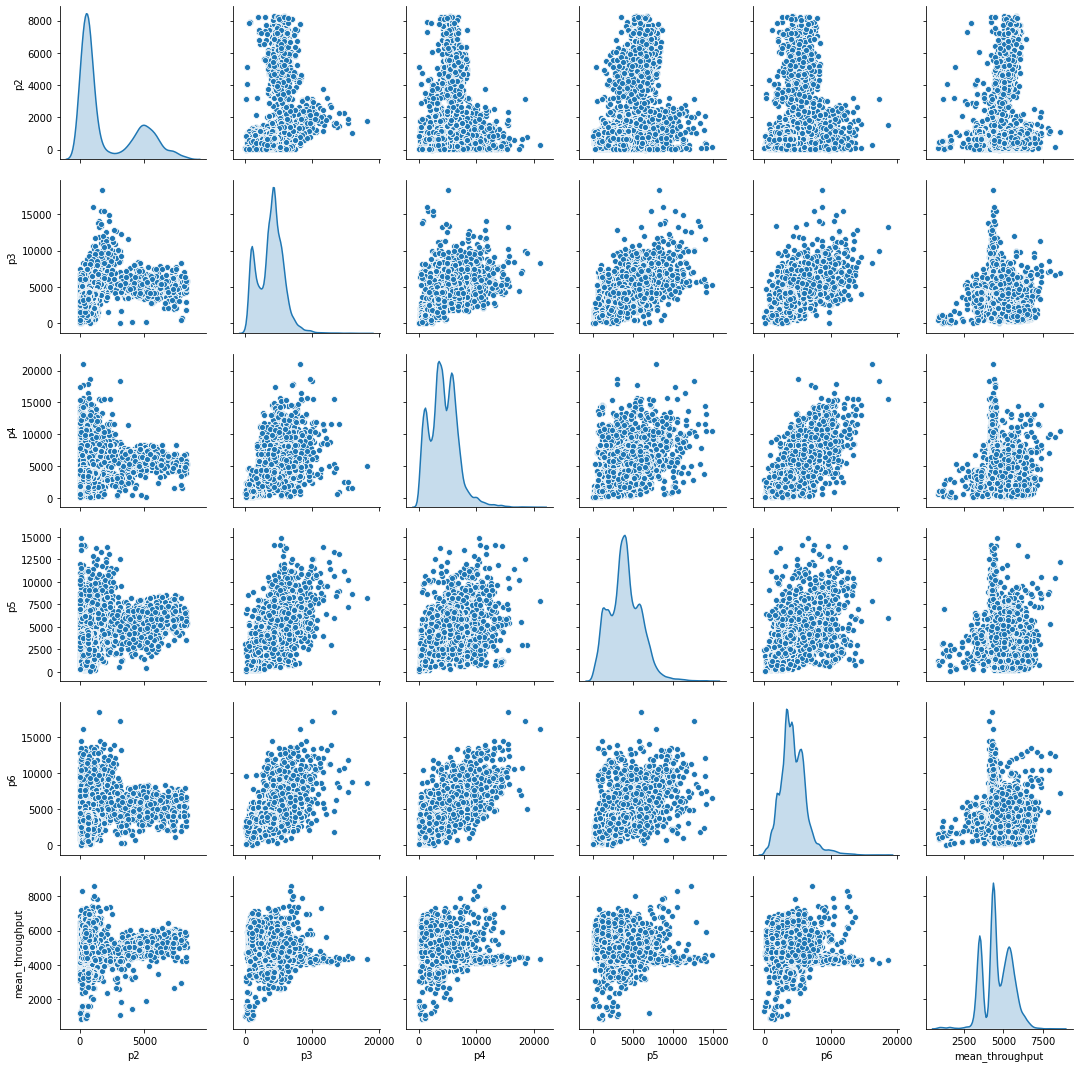

In [25]:
sns.pairplot(data[["p2", "p3", "p4", "p5", "p6", "mean_throughput"]], diag_kind="kde")
plt.show()

## Train and Test Data

In [30]:
train_dataset = data.sample(frac=0.8,random_state=0)
test_dataset = data.drop(train_dataset.index)

In [31]:
train_stats = train_dataset.describe()
train_stats.pop("mean_throughput")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
p2,14072.0,2105.041157,2253.056701,6.291456,494.927872,788.529152,4362.00000,8258.000000
p3,14072.0,3830.786216,1941.096645,0.000000,2388.492096,4041.000000,5045.00000,18297.651200
p4,14072.0,4329.594337,2457.272260,67.000000,2659.141552,4163.000000,5874.00000,21011.365888
p5,14072.0,4046.645466,1974.075390,67.000000,2685.588640,3972.000000,5326.19152,14891.876352
p6,14072.0,4365.154528,1908.967333,0.000000,3210.554784,4180.000000,5492.25000,18530.435072


In [32]:
train_labels = train_dataset.pop('mean_throughput')
test_labels = test_dataset.pop('mean_throughput')

## Normalization

In [33]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## Model

In [34]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [88]:
model = build_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                384       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 4,609
Trainable params: 4,609
Non-trainable params: 0
_________________________________________________________________


## Training

In [90]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [91]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
995,260567.032831,323.330444,260566.953125,238130.027931,310.080139,238130.062500,995
996,260863.941192,322.598236,260863.937500,240352.575033,316.781677,240352.531250,996
997,260147.386164,321.818024,260147.390625,241275.752864,317.760590,241275.703125,997
998,259492.723500,322.080627,259492.812500,247385.201227,324.511047,247385.140625,998
999,259980.872880,322.916016,259980.906250,239347.859974,316.296753,239347.812500,999


<Figure size 432x288 with 0 Axes>

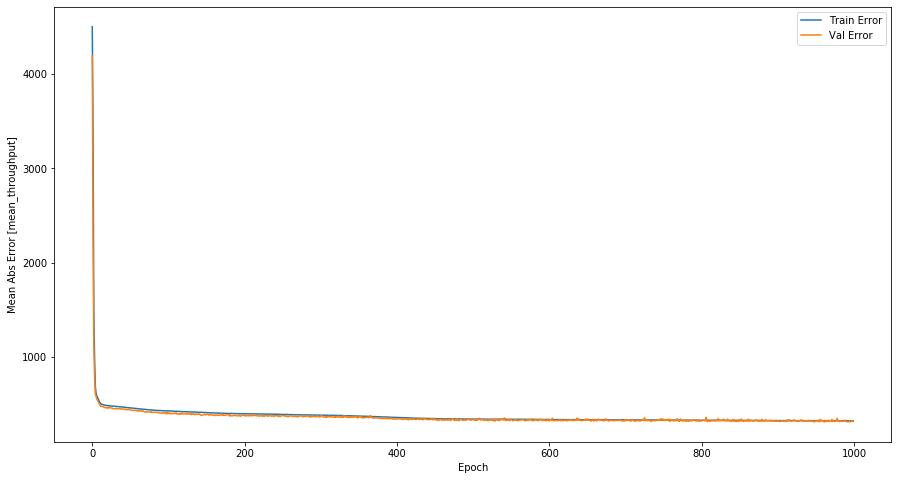

<Figure size 432x288 with 0 Axes>

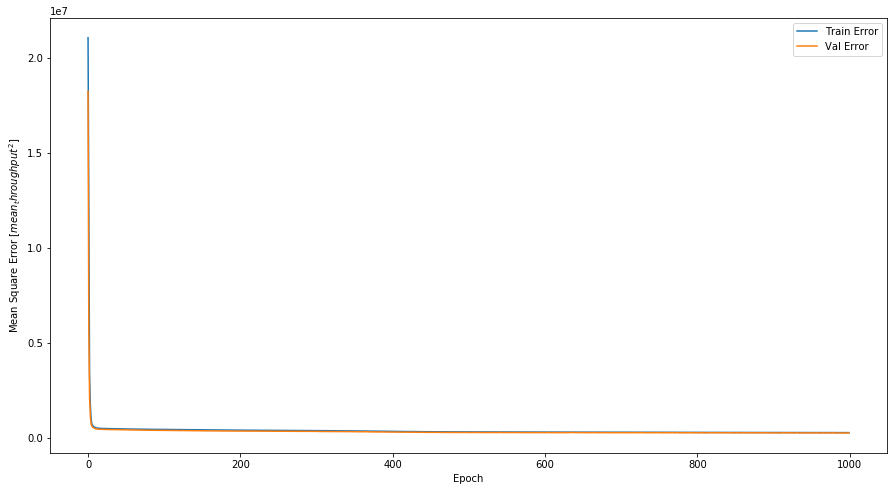

In [92]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.figure(figsize=(15,8))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [mean_throughput]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#   plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.figure(figsize=(15,8))
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$mean_throughput^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#   plt.ylim([0,20])
  plt.legend()
  plt.show();


plot_history(history)

## Training - Early Terminations if Possible


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
........................

<Figure size 432x288 with 0 Axes>

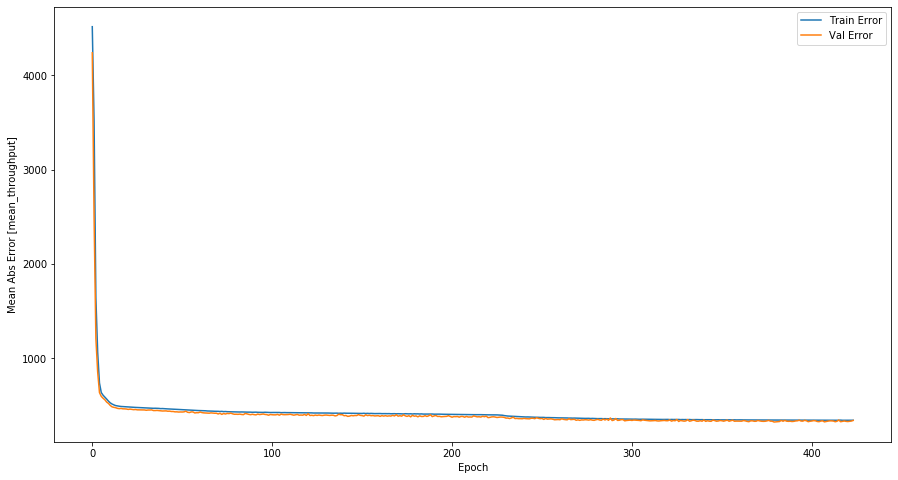

<Figure size 432x288 with 0 Axes>

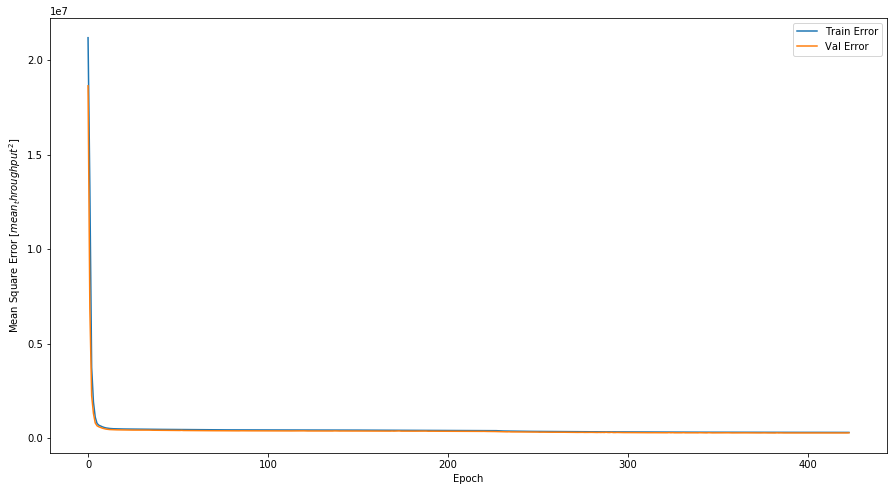

In [93]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

## Output

In [95]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))

Testing set Mean Abs Error: 347.16


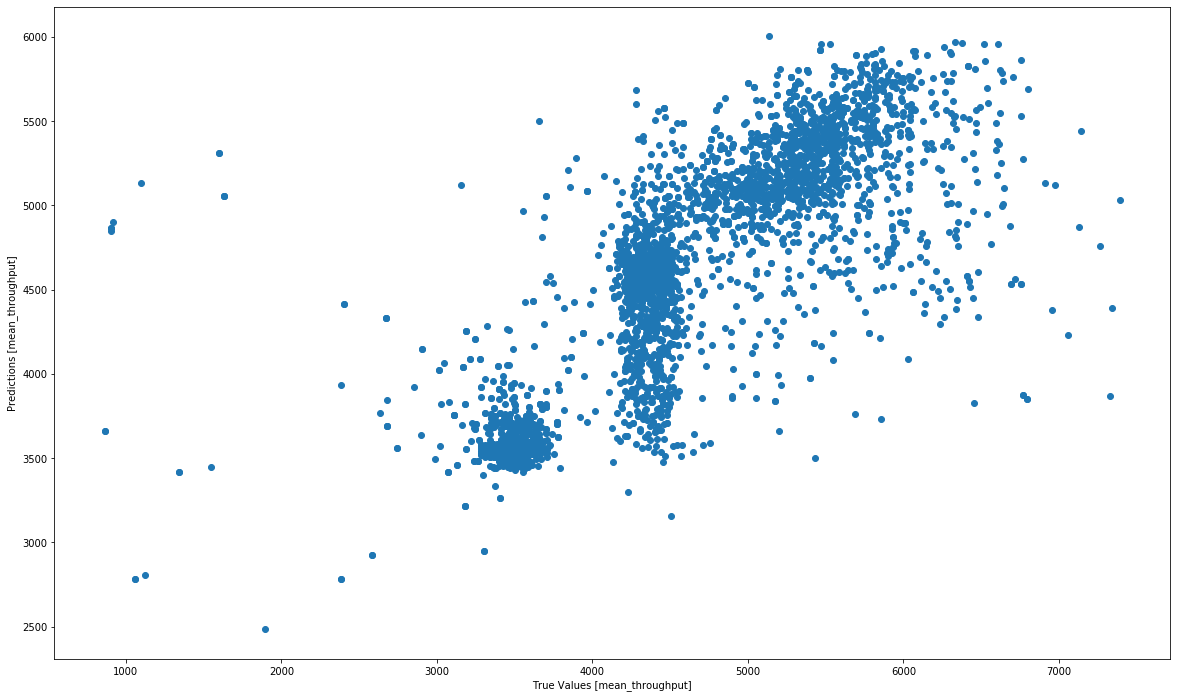

In [96]:
test_predictions = model.predict(normed_test_data).flatten()

plt.figure(figsize=(20,12))
plt.xlabel('True Values [mean_throughput]')
plt.ylabel('Predictions [mean_throughput]')
plt.scatter(test_labels, test_predictions)
# plt.axis('equal')
# plt.axis('square')
# plt.xlim([0,plt.xlim()[1]])
# plt.ylim([0,plt.ylim()[1]])
plt.show()
# _ = plt.plot([0, 0], [-100, 100])

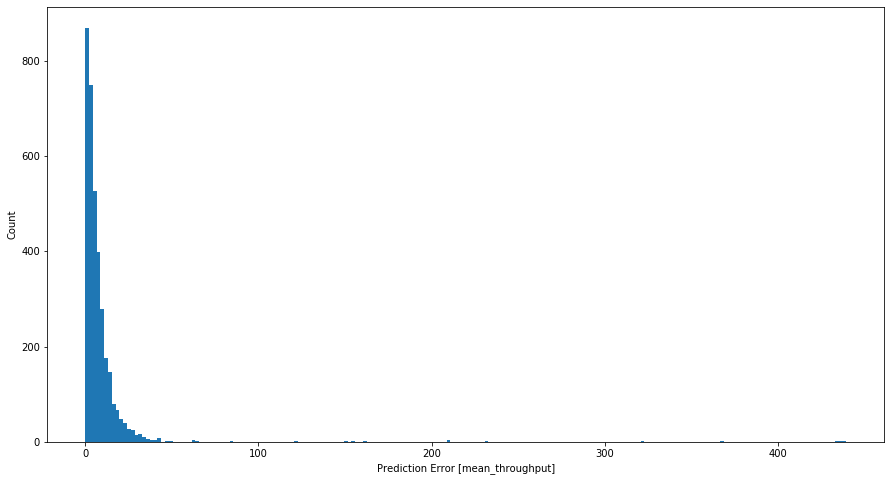

In [104]:
error = np.abs((test_predictions - test_labels)/test_labels) * 100
plt.figure(figsize=(15,8))
plt.hist(error, bins = 200)
plt.xlabel("Prediction Error [mean_throughput]")
_ = plt.ylabel("Count")

#### Error Rate

In [119]:
np.round(np.mean(error), 2)

8.38

#### Error Distribution

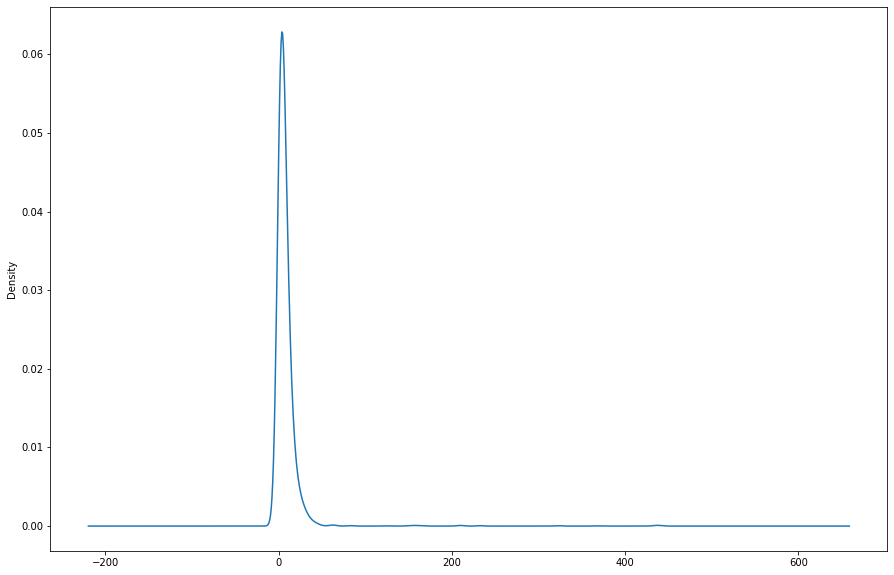

In [117]:
plt.figure(figsize=(15,10))
error.plot.kde();

#### Worst performing Data Points

In [115]:
error[error>100]

564      155.016102
674      322.469365
781      232.537810
964      209.552418
1684     439.088348
13215    162.022459
13224    149.768499
13260    155.016102
13734    435.242089
14760    209.552418
14880    439.088348
14892    366.664111
15415    162.022505
15847    122.391533
15860    209.552418
15978    434.331392
16670    322.469365
16777    232.537810
Name: mean_throughput, dtype: float64

In [114]:
data.loc[error[error>100].index,:]

,p2,p3,p4,p5,p6,mean_throughput
564,117.0,905.0,2730.0,2400.0,0.0,1341.161290
674,100.0,469.0,603.0,1207.0,1509.0,866.483871
781,553.0,1207.0,956.0,2969.0,1807.0,1597.709677
964,620.0,536.0,905.0,2415.0,2452.0,1632.709677
1684,422.0,1000.0,1020.0,956.0,887.0,902.774194
13215,100.0,0.0,805.0,3087.0,2449.0,1061.193548
13224,3137.0,25.0,1182.0,2113.0,1883.0,1124.129032
13260,117.0,905.0,2730.0,2400.0,0.0,1341.161290
13734,430.0,973.0,854.0,939.0,978.0,915.290323
14760,620.0,536.0,905.0,2415.0,2452.0,1632.709677
